
[Aşama 1/6] Kaydedilmiş ensemble modeli bulunamadı. Optimizasyon ve eğitim başlıyor...

PCA sonrası yeni öznitelik boyutu: 2301

[Aşama 2/6] Bireysel modeller için en iyi hiper-parametreler bulunuyor (Hızlı Mod)...
Hızlı hiper-parametre optimizasyonu için 7366 adet alt örneklem kullanılacak.
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Fitting 2 folds for each of 4 candidates, totalling 8 fits

[Aşama 3/6] Ensemble modeli için en iyi ağırlıklar bulunuyor (Hızlı Mod)...
En iyi Ensemble ağırlıkları bulundu: [0.5, 0.2, 0.3]

[Aşama 4/6] Final Ensemble modeli TÜM eğitim verisiyle eğitiliyor...

--- FİNAL ENSEMBLE MODEL DEĞERLENDİRME RAPORU ---
              precision    recall  f1-score   support

    airplane       0.94      0.94      0.94      2325
        bird       0.97      0.94      0.96      1349
       drone       1.00      1.00      1.00      3118
  helicopter       0.93      0.95      0.94      2416

    ac

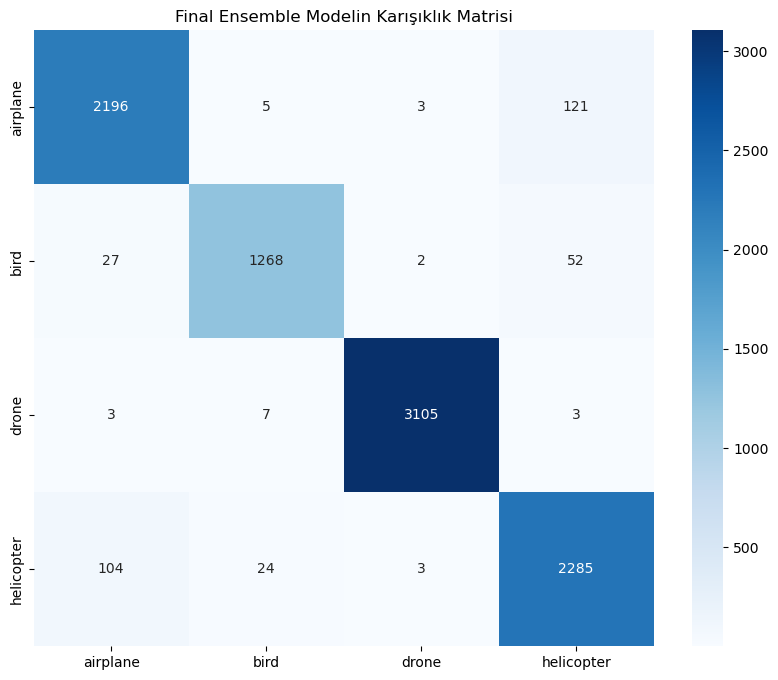


[Aşama 5/6] Final Ensemble modeli için en iyi güven eşikleri hesaplanıyor...
'airplane' sınıfı için optimal eşik (Max F1): 0.4600
'bird' sınıfı için optimal eşik (Max F1): 0.4778
'drone' sınıfı için optimal eşik (Max F1): 0.5097
'helicopter' sınıfı için optimal eşik (Max F1): 0.4580

[Aşama 6/6] Final Ensemble modeli ve yardımcılar 'ensemble_model_final_auto_weights.pkl' dosyasına kaydediliyor...

Tespit aşaması başlıyor...
Piramit Katmanı 1, Ölçek: 1.00, Boyut: (1024, 1024)


Katman 1 taranıyor: 361it [00:51,  7.06it/s]


Piramit Katmanı 2, Ölçek: 1.50, Boyut: (682, 682)


Katman 2 taranıyor: 144it [00:20,  7.00it/s]


Piramit Katmanı 3, Ölçek: 2.26, Boyut: (454, 454)


Katman 3 taranıyor: 49it [00:06,  7.03it/s]


Piramit Katmanı 4, Ölçek: 3.39, Boyut: (302, 302)


Katman 4 taranıyor: 16it [00:02,  7.02it/s]


Piramit Katmanı 5, Ölçek: 5.09, Boyut: (201, 201)


Katman 5 taranıyor: 4it [00:00,  7.00it/s]


Piramit Katmanı 6, Ölçek: 7.64, Boyut: (134, 134)


Katman 6 taranıyor: 1it [00:00,  7.16it/s]


Toplam 559 adet potansiyel nesne tespit edildi.

Sonuçlar filtreleniyor ve görselleştiriliyor...
Filtreleme sonrası 133 adet nesne kaldı.


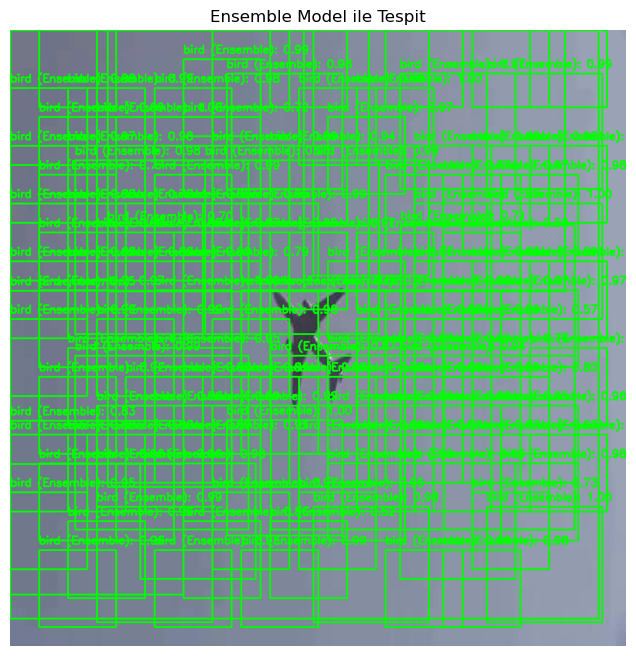

In [1]:
# Gerekli kütüphaneleri projemize dahil ediyoruz
import joblib
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

# =================================================================================
# --- Proje Ayarları ---
# =================================================================================
FEATURES_FILE = 'hog_color_lbp_glcm_augmented_4class.pkl'
TEST_IMAGE_PATH = "test_goruntusu.jpg"
ENSEMBLE_MODEL_FILE = 'ensemble_model_final_auto_weights.pkl'

# =================================================================================
# --- Yardımcı Fonksiyonlar Bölümü ---
# =================================================================================
BINS = 8
LBP_POINTS = 24
LBP_RADIUS = 8
GLCM_DISTANCES = [1, 2]
GLCM_ANGLES = [0, np.pi/4, np.pi/2, 3*np.pi/4]
GLCM_PROPERTIES = ['energy', 'contrast', 'homogeneity', 'correlation']
GLCM_LEVELS = 32

# ... (Tüm yardımcı fonksiyonlar - extract_color_histogram, extract_lbp_features, vb. - öncekiyle aynı, burada yer kaplamaması için kısaltıldı) ...
def extract_color_histogram(image, bins=(BINS, BINS, BINS)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()
def extract_lbp_features(gray_image):
    lbp = local_binary_pattern(gray_image, LBP_POINTS, LBP_RADIUS, method="uniform")
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_POINTS + 3), range=(0, LBP_POINTS + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    return lbp_hist
def extract_glcm_features(gray_image):
    img_for_glcm = (gray_image / 255.0 * (GLCM_LEVELS - 1)).astype(np.uint8)
    glcm = graycomatrix(img_for_glcm, GLCM_DISTANCES, GLCM_ANGLES, levels=GLCM_LEVELS, symmetric=True, normed=True)
    glcm_features = [graycoprops(glcm, prop).flatten() for prop in GLCM_PROPERTIES]
    return np.concatenate(glcm_features)
def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])
def pyramid(image, scale=1.5, minSize=(128, 128)):
    yield image
    while True:
        w = int(image.shape[1] / scale)
        image = cv2.resize(image, (w, int(image.shape[0] * (w / float(image.shape[1])))))
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image

# =================================================================================
# FAZ A: MODEL SEÇİMİ, ENSEMBLE OLUŞTURMA VE EŞİK OPTİMİZASYONU
# =================================================================================
if not os.path.exists(ENSEMBLE_MODEL_FILE):
    print(f"\n[Aşama 1/6] Kaydedilmiş ensemble modeli bulunamadı. Optimizasyon ve eğitim başlıyor...")
    data = joblib.load(FEATURES_FILE)
    X, y_text = data['features'], data['labels']
    le = LabelEncoder()
    y = le.fit_transform(y_text)
    class_names = le.classes_
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    print(f"\nPCA sonrası yeni öznitelik boyutu: {pca.n_components_}")

    print("\n[Aşama 2/6] Bireysel modeller için en iyi hiper-parametreler bulunuyor (Hızlı Mod)...")
    subset_ratio = 0.20 
    num_subset = int(len(X_train_pca) * subset_ratio)
    X_train_subset = X_train_pca[:num_subset]
    y_train_subset = y_train[:num_subset]
    print(f"Hızlı hiper-parametre optimizasyonu için {num_subset} adet alt örneklem kullanılacak.")
    
    models_to_test = {
        'SVM': (SVC(probability=True, random_state=42), {'C': [10, 50], 'gamma': [0.001, 0.0001]}),
        'MLP': (MLPClassifier(max_iter=500, random_state=42), {'hidden_layer_sizes': [(100,)], 'alpha': [0.001, 0.01]}),
        'XGBoost': (XGBClassifier(eval_metric='mlogloss', random_state=42), {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.05]})
    }
    best_estimators = {}
    for name, (model, params) in models_to_test.items():
        grid_search = GridSearchCV(model, params, cv=2, n_jobs=-1, verbose=1) ### DEĞİŞTİRİLDİ: cv=2 ###
        grid_search.fit(X_train_subset, y_train_subset) ### DEĞİŞTİRİLDİ: subset üzerinde arama ###
        best_estimators[name] = grid_search.best_estimator_
    
    ### YENİ BÖLÜM: ENSEMBLE AĞIRLIK OPTİMİZASYONU ###
    print("\n[Aşama 3/6] Ensemble modeli için en iyi ağırlıklar bulunuyor (Hızlı Mod)...")
    temp_estimators = [(name, model) for name, model in best_estimators.items()]
    # Ağırlık optimizasyonu için bir VotingClassifier ve denenecek ağırlık setleri
    voting_clf_for_search = VotingClassifier(estimators=temp_estimators, voting='soft')
    
    params_for_voting = {
        'weights': [
            [0.5, 0.2, 0.3], # SVM ağırlıklı
            [0.4, 0.3, 0.3], # Dengeli
            [0.3, 0.2, 0.5], # XGBoost ağırlıklı
            None             # Eşit ağırlık
        ]
    }
    
    # Ağırlıkları bulmak için yeni bir GridSearchCV
    grid_search_voting = GridSearchCV(estimator=voting_clf_for_search, 
                                      param_grid=params_for_voting, 
                                      cv=2, ### DEĞİŞTİRİLDİ: cv=2 ###
                                      scoring='accuracy',
                                      n_jobs=-1)
    
    grid_search_voting.fit(X_train_subset, y_train_subset) ### DEĞİŞTİRİLDİ: subset üzerinde arama ###
    print(f"En iyi Ensemble ağırlıkları bulundu: {grid_search_voting.best_params_['weights']}")
    
    # En iyi ağırlıklara sahip final ensemble modelini al
    ensemble_model = grid_search_voting.best_estimator_
    ### BİTTİ ###
    
    print("\n[Aşama 4/6] Final Ensemble modeli TÜM eğitim verisiyle eğitiliyor...")
    ensemble_model.fit(X_train_pca, y_train)
    
    print("\n--- FİNAL ENSEMBLE MODEL DEĞERLENDİRME RAPORU ---")
    y_pred_ensemble = ensemble_model.predict(X_test_pca)
    print(classification_report(y_test, y_pred_ensemble, target_names=class_names))
    
    print("\n--- FİNAL ENSEMBLE MODEL KARIŞIKLIK MATRİSİ ---")
    conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_ensemble, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Final Ensemble Modelin Karışıklık Matrisi')
    plt.show()

    print("\n[Aşama 5/6] Final Ensemble modeli için en iyi güven eşikleri hesaplanıyor...")
    y_probas = ensemble_model.predict_proba(X_test_pca)
    optimal_thresholds = {}
    for i, class_name in enumerate(class_names):
        precision, recall, thresholds = precision_recall_curve(y_test, y_probas[:, i], pos_label=i)
        f1_scores = np.nan_to_num(2 * recall[:-1] * precision[:-1] / (recall[:-1] + precision[:-1]))
        if len(f1_scores) == 0:
            optimal_thresholds[class_name] = 0.5 # Eğer hiç pozitif örnek yoksa varsayılan
            continue
        best_f1_idx = np.argmax(f1_scores)
        optimal_thresholds[class_name] = thresholds[best_f1_idx]
        print(f"'{class_name}' sınıfı için optimal eşik (Max F1): {optimal_thresholds[class_name]:.4f}")

    print(f"\n[Aşama 6/6] Final Ensemble modeli ve yardımcılar '{ENSEMBLE_MODEL_FILE}' dosyasına kaydediliyor...")
    joblib.dump({
        'model': ensemble_model, 'scaler': scaler, 'pca': pca, 
        'le': le, 'class_names': class_names, 'thresholds': optimal_thresholds
    }, ENSEMBLE_MODEL_FILE)

else:
    print(f"\nKaydedilmiş '{ENSEMBLE_MODEL_FILE}' dosyası bulundu. Model doğrudan yükleniyor.")

if 'ensemble_model' not in locals():
    saved_data = joblib.load(ENSEMBLE_MODEL_FILE)
    ensemble_model, scaler, pca, le, class_names, optimal_thresholds = \
        saved_data['model'], saved_data['scaler'], saved_data['pca'], \
        saved_data['le'], saved_data['class_names'], saved_data['thresholds']

# =================================================================================
# FAZ B ve FAZ C (Bu kısımlarda bir değişiklik yok)
# =================================================================================
# ... (Kodun geri kalanı tamamen aynı, burada yer kaplamaması için kısaltıldı) ...
print("\nTespit aşaması başlıyor...")

(winW, winH) = (128, 128)
step_size = 48
image = cv2.imread(TEST_IMAGE_PATH)
if image is None: print(f"HATA: Test görüntüsü '{TEST_IMAGE_PATH}' yüklenemedi."); exit()
clone = image.copy()
detections = []

PIXELS_PER_CELL, CELLS_PER_BLOCK, ORIENTATIONS = (8, 8), (2, 2), 9

for i, resized in enumerate(pyramid(image, scale=1.5)):
    scale_factor = image.shape[1] / float(resized.shape[1])
    print(f"Piramit Katmanı {i+1}, Ölçek: {scale_factor:.2f}, Boyut: {resized.shape[:2]}")
    for (x, y, window) in tqdm(sliding_window(resized, step_size=step_size, window_size=(winW, winH)), desc=f"Katman {i+1} taranıyor"):
        if window.shape[0] != winH or window.shape[1] != winW: continue
        
        color_window = window
        gray_window = cv2.cvtColor(color_window, cv2.COLOR_BGR2GRAY)
        
        hog_features = hog(gray_window, orientations=ORIENTATIONS, pixels_per_cell=PIXELS_PER_CELL, cells_per_block=CELLS_PER_BLOCK, block_norm='L2-Hys')
        color_features = extract_color_histogram(color_window)
        lbp_features = extract_lbp_features(gray_window)
        glcm_features = extract_glcm_features(gray_window)
        
        combined_features = np.concatenate([hog_features, color_features, lbp_features, glcm_features])
        features_scaled = scaler.transform([combined_features])
        features_pca = pca.transform(features_scaled)

        pred_proba_all_classes = ensemble_model.predict_proba(features_pca)[0]
        predicted_class_index = np.argmax(pred_proba_all_classes)
        max_proba = pred_proba_all_classes[predicted_class_index]
        class_label = le.inverse_transform([predicted_class_index])[0]
        
        confidence_threshold = optimal_thresholds.get(class_label, 0.99)
        
        if max_proba > confidence_threshold: 
            if class_label in ['bird', 'drone', 'airplane', 'helicopter']:
                startX, startY = int(x * scale_factor), int(y * scale_factor)
                endX, endY = int((x + winW) * scale_factor), int((y + winH) * scale_factor)
                box = (startX, startY, endX, endY)
                detections.append((box, max_proba, class_label, "Ensemble")) 

print(f"Toplam {len(detections)} adet potansiyel nesne tespit edildi.")

print("\nSonuçlar filtreleniyor ve görselleştiriliyor...")
final_detections = []
detections.sort(key=lambda d: d[1], reverse=True) 
while len(detections) > 0:
    best_detection = detections.pop(0)
    final_detections.append(best_detection)
    (box1, _, _, _) = best_detection
    remaining_detections = []
    for other_detection in detections:
        (box2, _, _, _) = other_detection
        (x1_a, y1_a, x2_a, y2_a) = box1
        (x1_b, y1_b, x2_b, y2_b) = box2
        xA, yA = max(x1_a, x1_b), max(y1_a, y1_b)
        xB, yB = min(x2_a, x2_b), min(y2_a, y2_b)
        interArea = max(0, xB - xA) * max(0, yB - yA)
        if interArea == 0:
            remaining_detections.append(other_detection)
            continue
        boxAArea = (x2_a - x1_a) * (y2_a - y1_a)
        boxBArea = (x2_b - x1_b) * (y2_b - y1_b)
        iou = interArea / float(boxAArea + boxBArea - interArea)
        if iou < 0.3: 
            remaining_detections.append(other_detection)
    detections = remaining_detections

print(f"Filtreleme sonrası {len(final_detections)} adet nesne kaldı.")

model_colors = {'Ensemble': (0, 255, 0)}

for (box, proba, label, model_name) in final_detections:
    (startX, startY, endX, endY) = box
    color = model_colors.get(model_name, (255, 255, 255)) 
    cv2.rectangle(clone, (startX, startY), (endX, endY), color, 2)
    label_text = f"{label} ({model_name}): {proba:.2f}"
    cv2.putText(clone, label_text, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
plt.title("Ensemble Model ile Tespit")
plt.axis('off')
plt.show()
